In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
xgb.__version__

''

In [4]:
df=pd.read_csv('../input/train2016_withy.csv')

In [5]:
#df=df.loc[np.random.permutation(df.index)]

In [6]:
trainx=df[['year','month']]
trainy=df['logerror']

In [7]:
trainx.shape

(90275, 2)

In [24]:
def mae(y,m=None):
    if m is None: m=np.median(y)
    return np.mean(np.abs(y-m))

In [9]:
#split = 80000
#x_train, y_train, x_valid, y_valid = trainx[:split], trainy[:split], trainx[split:], trainy[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(trainx, label=trainy )
#d_valid = xgb.DMatrix(x_valid, label=y_valid)




Building DMatrix...


In [10]:
mae(trainy),np.mean(np.abs(trainy))

(0.06813404707837792, 0.06844671392966638)

In [11]:
print('Training ...')

params = {}
params['eta'] = 0.005
params['objective'] = 'reg:smoothl1'
#params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 10
#params['subsample'] = 0.7
#params['colsample_bytree'] = 0.8
params['silent'] = 1
params['base_score'] = np.median(trainy)
params['min_child_weight']=3
#params['tree_method']='hist'

watchlist = [(d_train, 'train')]
clf = xgb.train(params, d_train, 160, watchlist, early_stopping_rounds=50, verbose_eval=10)


Training ...
[0]	train-mae:0.068118
Will train until train-mae hasn't improved in 50 rounds.
[10]	train-mae:0.068052
[20]	train-mae:0.068042
[30]	train-mae:0.06804
[40]	train-mae:0.06804
[50]	train-mae:0.06804
[60]	train-mae:0.06804
[70]	train-mae:0.06804
Stopping. Best iteration:
[28]	train-mae:0.06804



In [12]:
predy=clf.predict(d_train)

In [13]:
resy=trainy-predy

In [14]:
mae(trainy),np.mean(np.abs(trainy)),mae(resy),np.mean(np.abs(resy))

(0.06813404707837792,
 0.06844671392966638,
 0.0680395391694652,
 0.06803960190429434)

In [15]:
df['resy']=resy

In [16]:
a=df[['logerror','resy','year','month']]
a['year_month']=a.year*100+a.month

/home/spark/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


201601     6556
201602     6333
201603     8652
201604     9311
201605     9961
201606    10922
201607     9947
201608    10476
201609     9575
201610     4977
201611     1826
201612     1739
Name: year_month, dtype: int64

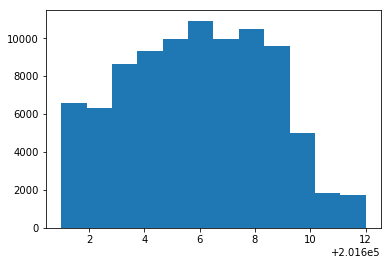

In [18]:
plt.hist(a.year_month,bins=12)
a.year_month.value_counts().sort_index()

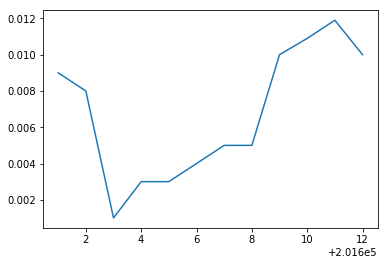

In [19]:
b=a[['year_month','logerror']].groupby('year_month').apply(lambda u: np.median(u['logerror'])).sort_index()
plt.plot(b.index,b.values)

year_month
201601    0.071936
201602    0.076806
201603    0.072027
201604    0.069895
201605    0.066146
201606    0.066006
201607    0.064810
201608    0.065831
201609    0.066308
201610    0.063605
201611    0.062636
201612    0.074896
dtype: float64

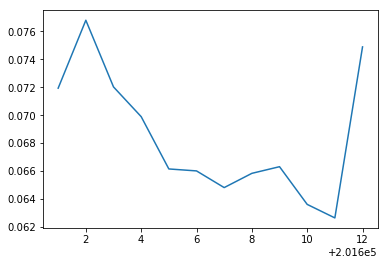

In [26]:
b=a[['year_month','logerror']].groupby('year_month').apply(lambda u: mae(u['logerror'])).sort_index()
plt.plot(b.index,b.values)
b

In [29]:
(0.064746+0.063965+0.075952)/3,(0.063605+0.062636+0.074896)/3

(0.06822099999999999, 0.06704566666666667)

year_month
201601    0.072695
201602    0.077434
201603    0.072044
201604    0.069972
201605    0.066241
201606    0.066158
201607    0.065044
201608    0.066104
201609    0.067279
201610    0.064746
201611    0.063965
201612    0.075952
dtype: float64

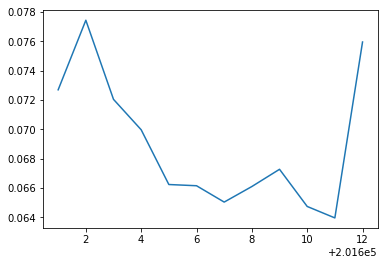

In [27]:
b=a[['year_month','logerror']].groupby('year_month').apply(lambda u: mae(u['logerror'],0)).sort_index()
plt.plot(b.index,b.values)
b

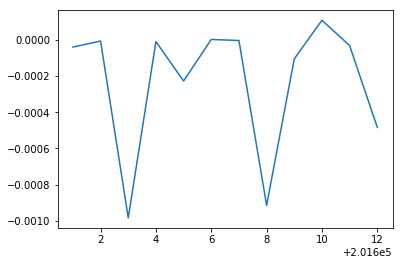

In [21]:
b=a[['year_month','resy']].groupby('year_month').apply(lambda u: np.median(u['resy'])).sort_index()
plt.plot(b.index,b.values)

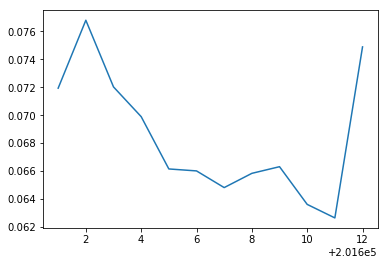

In [22]:
b=a[['year_month','resy']].groupby('year_month').apply(lambda u: mae(u['resy'])).sort_index()
plt.plot(b.index,b.values)

In [58]:
df['resy']=resy

In [59]:
df.to_csv('../input/train2016_withresy',index=None)

In [69]:
t=pd.DataFrame([[2016,10],[2016,11],[2016,12]],columns=trainx.columns)

In [70]:
t

year  month
0  2016     10
1  2016     11
2  2016     12

In [71]:
clf.predict(xgb.DMatrix(t))

array([ 0.01079176,  0.01193181,  0.01048354], dtype=float32)